# Demo EfficientLoFTR on a single pair of images and 3d gaussian splatting reconstruction

This notebook shows how to use the eloftr matcher with different model type and numerical precision on the pretrained weights.

In [1]:
import os
# os.chdir("..")
from copy import deepcopy

import sys
sys.path.append('../thirdparty/EfficientLoFTR')

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 添加字体文件
font_path = '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc'
fm.fontManager.addfont(font_path)

# 获取字体名称（确保正确）
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()  # 应返回 'WenQuanYi Micro Hei' 或类似名称
print(f"Loaded font name: {font_name}")

# 设置全局字体
plt.rcParams['font.sans-serif'] = [font_name]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

import torch
import cv2
import numpy as np
import matplotlib.cm as cm
from src.utils.plotting import make_matching_figure



Loaded font name: WenQuanYi Micro Hei


## Outdoor Example

We recommend using our pre-trained model for input in outdoor environments because our model has only been trained on MegaDepth, and there exists a domain gap between indoor and outdoor data.

In [2]:
from src.loftr import LoFTR, full_default_cfg, opt_default_cfg, reparameter

# You can choose model type in ['full', 'opt']
model_type = 'full' # 'full' for best quality, 'opt' for best efficiency

# You can choose numerical precision in ['fp32', 'mp', 'fp16']. 'fp16' for best efficiency
precision = 'fp32' # Enjoy near-lossless precision with Mixed Precision (MP) / FP16 computation if you have a modern GPU (recommended NVIDIA architecture >= SM_70).

# You can also change the default values like thr. and npe (based on input image size)

if model_type == 'full':
    _default_cfg = deepcopy(full_default_cfg)
elif model_type == 'opt':
    _default_cfg = deepcopy(opt_default_cfg)
    
if precision == 'mp':
    _default_cfg['mp'] = True
elif precision == 'fp16':
    _default_cfg['half'] = True
    
print(_default_cfg)
matcher = LoFTR(config=_default_cfg)

matcher.load_state_dict(torch.load("../thirdparty/EfficientLoFTR/weights/eloftr_outdoor.ckpt", weights_only=False)['state_dict'])
matcher = reparameter(matcher) # no reparameterization will lead to low performance

if precision == 'fp16':
    matcher = matcher.half()

matcher = matcher.eval().cuda()

{'backbone_type': 'RepVGG', 'align_corner': False, 'resolution': (8, 1), 'fine_window_size': 8, 'mp': False, 'replace_nan': True, 'half': False, 'backbone': {'block_dims': [64, 128, 256]}, 'coarse': {'d_model': 256, 'd_ffn': 256, 'nhead': 8, 'layer_names': ['self', 'cross', 'self', 'cross', 'self', 'cross', 'self', 'cross'], 'agg_size0': 4, 'agg_size1': 4, 'no_flash': False, 'rope': True, 'npe': [832, 832, 832, 832]}, 'match_coarse': {'thr': 0.2, 'border_rm': 2, 'dsmax_temperature': 0.1, 'skip_softmax': False, 'fp16matmul': False, 'train_coarse_percent': 0.2, 'train_pad_num_gt_min': 200}, 'match_fine': {'local_regress_temperature': 10.0, 'local_regress_slicedim': 8}}


In [3]:
# Load example images
img0_pth = "../assets/camera_output/0.png"
img1_pth = "../assets/camera_output/2.png"
img0_raw = cv2.imread(img0_pth, cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(img1_pth, cv2.IMREAD_GRAYSCALE)
img0_raw = cv2.resize(img0_raw, (img0_raw.shape[1]//32*32, img0_raw.shape[0]//32*32))  # input size shuold be divisible by 32
img1_raw = cv2.resize(img1_raw, (img1_raw.shape[1]//32*32, img1_raw.shape[0]//32*32))

if precision == 'fp16':
    img0 = torch.from_numpy(img0_raw)[None][None].half().cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].half().cuda() / 255.
else:
    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with EfficientLoFTR and get prediction
with torch.no_grad():
    if precision == 'mp':
        with torch.autocast(enabled=True, device_type='cuda'):
            matcher(batch)
    else:
        matcher(batch)
    mkpts0 = batch['mkpts0_f'].cpu().numpy()
    mkpts1 = batch['mkpts1_f'].cpu().numpy()
    mconf = batch['mconf'].cpu().numpy()

/home/surgicalai/anaconda3/envs/ELGS/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4317.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


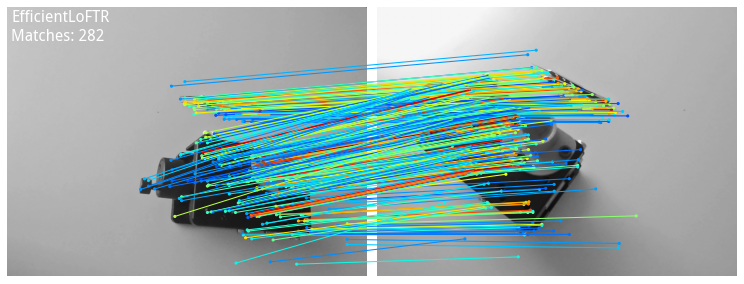

In [4]:
# 特征匹配可视化
if model_type == 'opt':
    print(mconf.max())
    mconf_display = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))
else:
    mconf_display = mconf

color = cm.jet(mconf_display)
text = [
    'EfficientLoFTR',
    'Matches: {}'.format(len(mkpts0)),
]
fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, text=text)

In [5]:
# 完整的3D重建流程 - 从特征匹配到3D点云生成

# 1. 设置相机内参（需要根据实际相机标定结果调整）
fx, fy = 1000.0, 1000.0  # 焦距参数
cx, cy = img0_raw.shape[1] / 2, img0_raw.shape[0] / 2  # 主点（图像中心）

# 构建相机内参矩阵
cameraMatrix = np.array([[fx, 0, cx], 
                         [0, fy, cy], 
                         [0, 0, 1]], dtype=np.float32)

# 畸变系数（假设无畸变）
distCoeffs = np.zeros((4, 1), dtype=np.float32)

print("=== 3D重建流程开始 ===")
print(f"相机内参矩阵：")
print(cameraMatrix)
print(f"原始匹配点数量：{len(mkpts0)}")
print(f"图像尺寸：{img0_raw.shape}")

# 2. 过滤高置信度的匹配点
confidence_threshold = 0
if model_type == 'opt':
    # 对opt模型的置信度进行归一化
    mconf_normalized = (mconf - min(20.0, mconf.min())) / (max(30.0, mconf.max()) - min(20.0, mconf.min()))
    high_conf_mask = mconf_normalized > confidence_threshold
else:
    high_conf_mask = mconf > confidence_threshold

# 获取高置信度的匹配点
points1_filtered = mkpts0[high_conf_mask]
points2_filtered = mkpts1[high_conf_mask]

points1_filtered = mkpts0[high_conf_mask]
points2_filtered = mkpts1[high_conf_mask]

print(f"\\n高置信度匹配点数：{len(points1_filtered)}")

# 3. 计算本质矩阵和恢复姿态
if len(points1_filtered) < 5:
    print("警告：高置信度匹配点数量过少，无法进行可靠的3D重建")
    points_3d_filtered = np.array([])  # 空数组
else:
    # 计算本质矩阵
    E, mask = cv2.findEssentialMat(points1_filtered, points2_filtered, cameraMatrix, 
                                   method=cv2.RANSAC, prob=0.999, threshold=1.0)
    
    # 恢复相对姿态
    _, R, t, pose_mask = cv2.recoverPose(E, points1_filtered, points2_filtered, cameraMatrix, mask=mask)
    
    print(f"RANSAC内点数量：{mask.sum()}")
    print(f"旋转矩阵 R：")
    print(R)
    print(f"平移向量 t：")
    print(t.flatten())
    
    # 4. 三角化生成3D点云
    if mask.sum() >= 5:
        # 使用RANSAC内点进行三角化
        inlier_points1 = points1_filtered[mask.ravel().astype(bool)]
        inlier_points2 = points2_filtered[mask.ravel().astype(bool)]
        
        # 构建投影矩阵
        # 第一相机：世界坐标系原点（单位矩阵）
        projMatrix1 = np.hstack((np.eye(3, dtype=np.float32), np.zeros((3, 1), dtype=np.float32)))
        projMatrix1 = cameraMatrix @ projMatrix1
        
        # 第二相机：相对姿态
        projMatrix2 = np.hstack((R, t))
        projMatrix2 = cameraMatrix @ projMatrix2
        
        # 三角化得到3D点
        points_3d_homogeneous = cv2.triangulatePoints(projMatrix1, projMatrix2, 
                                                       inlier_points1.T, inlier_points2.T)
        points_3d = points_3d_homogeneous[:3] / points_3d_homogeneous[3]  # 转换为非齐次坐标
        points_3d = points_3d.T  # 转置为Nx3格式
        
        # 5. 深度过滤
        depth_threshold = 50.0  # 深度阈值
        valid_depth_mask = (np.abs(points_3d[:, 2]) < depth_threshold) & (points_3d[:, 2] > 0)
        points_3d_filtered = points_3d[valid_depth_mask]
        
        print(f"\\n三角化得到的3D点数量：{len(points_3d)}")
        print(f"深度过滤后的3D点数量：{len(points_3d_filtered)}")
        
        if len(points_3d_filtered) > 0:
            print(f"3D点云统计信息：")
            print(f"  X范围: [{points_3d_filtered[:, 0].min():.3f}, {points_3d_filtered[:, 0].max():.3f}]")
            print(f"  Y范围: [{points_3d_filtered[:, 1].min():.3f}, {points_3d_filtered[:, 1].max():.3f}]")
            print(f"  Z范围: [{points_3d_filtered[:, 2].min():.3f}, {points_3d_filtered[:, 2].max():.3f}]")
            
            # 显示前几个3D点坐标
            print("\\n前10个3D点坐标：")
            for i, point in enumerate(points_3d_filtered[:10]):
                print(f"点 {i+1}: ({point[0]:.3f}, {point[1]:.3f}, {point[2]:.3f})")
        else:
            print("深度过滤后无有效3D点")
            points_3d_filtered = np.array([])
    else:
        print("RANSAC内点数量不足，无法进行三角化")
        points_3d_filtered = np.array([])

=== 3D重建流程开始 ===
相机内参矩阵：
[[1000.    0.  320.]
 [   0. 1000.  240.]
 [   0.    0.    1.]]
原始匹配点数量：282
图像尺寸：(480, 640)
\n高置信度匹配点数：282
RANSAC内点数量：122
旋转矩阵 R：
[[ 0.64115028 -0.46348789  0.61164147]
 [ 0.25121642  0.87986171  0.40340262]
 [-0.72513215 -0.10498732  0.68055935]]
平移向量 t：
[-0.79632877 -0.53516183  0.28189058]
\n三角化得到的3D点数量：122
深度过滤后的3D点数量：122
3D点云统计信息：
  X范围: [-0.023, 0.233]
  Y范围: [-0.092, 0.185]
  Z范围: [1.034, 1.247]
\n前10个3D点坐标：
点 1: (-0.015, -0.089, 1.169)
点 2: (-0.005, -0.092, 1.171)
点 3: (0.015, -0.089, 1.171)
点 4: (0.024, -0.090, 1.177)
点 5: (-0.006, -0.080, 1.166)
点 6: (-0.004, -0.084, 1.172)
点 7: (0.015, -0.083, 1.179)
点 8: (0.024, -0.088, 1.178)
点 9: (0.042, -0.082, 1.186)
点 10: (0.043, -0.089, 1.190)


创建输出文件夹: output
\n=== 文件保存完成 ===
TXT格式: output/reconstructed_3d_points_with_color.txt
PLY格式: output/reconstructed_3d_points.ply
保存的3D点数量: 122
\n⚠️  注意：XYZ坐标单位为相对像素单位，不是物理单位
   如需真实物理尺寸，需要相机标定和已知物理尺度


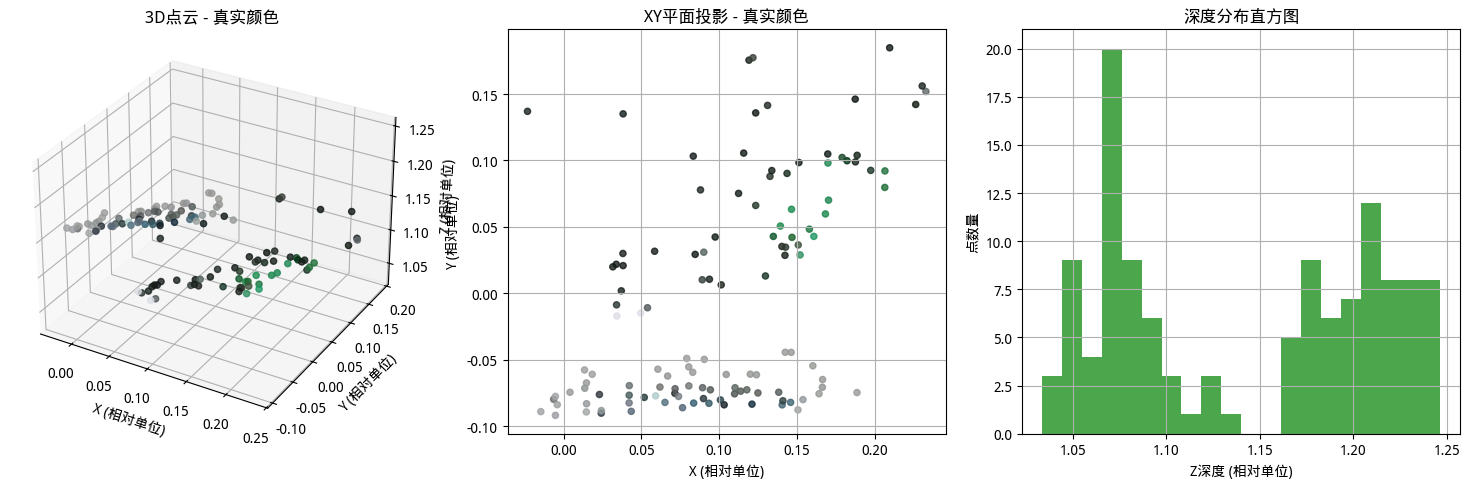

\n=== RGB颜色统计 ===
红色通道 - 均值: 74.9, 范围: [0, 220]
绿色通道 - 均值: 93.4, 范围: [21, 224]
蓝色通道 - 均值: 86.7, 范围: [16, 232]


In [6]:
# 3D点云可视化和数据保存（包含RGB颜色）

if len(points_3d_filtered) > 0:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    import os
    
    # 创建output文件夹
    output_dir = "output"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"创建输出文件夹: {output_dir}")
    
    # 读取原始彩色图像用于提取RGB信息
    img0_color = cv2.imread(img0_pth, cv2.IMREAD_COLOR)
    img1_color = cv2.imread(img1_pth, cv2.IMREAD_COLOR)
    
    # 调整尺寸以匹配处理后的图像
    img0_color = cv2.resize(img0_color, (img0_raw.shape[1], img0_raw.shape[0]))
    img1_color = cv2.resize(img1_color, (img1_raw.shape[1], img1_raw.shape[0]))
    
    # 转换BGR到RGB
    img0_rgb = cv2.cvtColor(img0_color, cv2.COLOR_BGR2RGB)
    img1_rgb = cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB)
    
    # 获取对应的2D点坐标（经过深度过滤后的）
    num_valid_points = len(points_3d_filtered)
    if 'valid_depth_mask' in locals() and 'inlier_points1' in locals():
        # 获取与有效3D点对应的2D点
        valid_inlier_indices = np.where(valid_depth_mask)[0]
        corresponding_2d_points1 = inlier_points1[valid_inlier_indices] if len(valid_inlier_indices) == num_valid_points else inlier_points1[:num_valid_points]
        corresponding_2d_points2 = inlier_points2[valid_inlier_indices] if len(valid_inlier_indices) == num_valid_points else inlier_points2[:num_valid_points]
    else:
        # 备用方案：使用前N个内点
        corresponding_2d_points1 = inlier_points1[:num_valid_points] if 'inlier_points1' in locals() else points1_filtered[:num_valid_points]
        corresponding_2d_points2 = inlier_points2[:num_valid_points] if 'inlier_points2' in locals() else points2_filtered[:num_valid_points]
    
    # 从两个视图中提取RGB颜色（使用第一个视图作为主要颜色源）
    colors_rgb = []
    for i, (pt1, pt2) in enumerate(zip(corresponding_2d_points1, corresponding_2d_points2)):
        if i >= len(points_3d_filtered):
            break
            
        # 确保坐标在图像范围内
        x1, y1 = int(np.clip(pt1[0], 0, img0_rgb.shape[1]-1)), int(np.clip(pt1[1], 0, img0_rgb.shape[0]-1))
        x2, y2 = int(np.clip(pt2[0], 0, img1_rgb.shape[1]-1)), int(np.clip(pt2[1], 0, img1_rgb.shape[0]-1))
        
        # 从第一个视图提取颜色（也可以选择平均两个视图的颜色）
        rgb1 = img0_rgb[y1, x1]  # 注意：图像坐标是[y, x]
        rgb2 = img1_rgb[y2, x2]
        
        # 使用第一个视图的颜色，或者可以选择平均颜色
        rgb_color = rgb1  # 或者 (rgb1 + rgb2) // 2 来平均两个视图的颜色
        colors_rgb.append(rgb_color)
    
    colors_rgb = np.array(colors_rgb)
    
    # 创建带颜色的3D点云数据
    points_with_color = np.hstack([points_3d_filtered[:len(colors_rgb)], colors_rgb])
    
    # 保存为文本文件 (x, y, z, r, g, b)
    output_file = os.path.join(output_dir, 'reconstructed_3d_points_with_color.txt')
    np.savetxt(output_file, points_with_color, 
               fmt='%.6f %.6f %.6f %d %d %d', 
               header='X Y Z R G B coordinates (pixel units and RGB 0-255)', 
               comments='# ')
    
    # 也保存为PLY格式（更标准的3D点云格式）
    ply_file = os.path.join(output_dir, 'reconstructed_3d_points.ply')
    with open(ply_file, 'w') as f:
        f.write("ply\\n")
        f.write("format ascii 1.0\\n")
        f.write(f"element vertex {len(points_with_color)}\\n")
        f.write("property float x\\n")
        f.write("property float y\\n")
        f.write("property float z\\n")
        f.write("property uchar red\\n")
        f.write("property uchar green\\n")
        f.write("property uchar blue\\n")
        f.write("end_header\\n")
        
        for point in points_with_color:
            f.write(f"{point[0]:.6f} {point[1]:.6f} {point[2]:.6f} {int(point[3])} {int(point[4])} {int(point[5])}\\n")
    
    print(f"\\n=== 文件保存完成 ===")
    print(f"TXT格式: {output_file}")
    print(f"PLY格式: {ply_file}")
    print(f"保存的3D点数量: {len(points_with_color)}")
    print(f"\\n⚠️  注意：XYZ坐标单位为相对像素单位，不是物理单位")
    print(f"   如需真实物理尺寸，需要相机标定和已知物理尺度")
    
    # 创建3D散点图（带颜色）
    fig = plt.figure(figsize=(15, 5))
    
    # 子图1：3D点云视图（带真实颜色）
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(points_3d_filtered[:len(colors_rgb), 0], 
                points_3d_filtered[:len(colors_rgb), 1], 
                points_3d_filtered[:len(colors_rgb), 2], 
                c=colors_rgb/255.0, s=20, alpha=0.8)  # 归一化颜色到[0,1]
    ax1.set_xlabel('X (相对单位)')
    ax1.set_ylabel('Y (相对单位)')
    ax1.set_zlabel('Z (相对单位)')
    ax1.set_title('3D点云 - 真实颜色')
    
    # 子图2：XY平面投影（带颜色）
    ax2 = fig.add_subplot(132)
    ax2.scatter(points_3d_filtered[:len(colors_rgb), 0], 
                points_3d_filtered[:len(colors_rgb), 1], 
                c=colors_rgb/255.0, s=20, alpha=0.8)
    ax2.set_xlabel('X (相对单位)')
    ax2.set_ylabel('Y (相对单位)')
    ax2.set_title('XY平面投影 - 真实颜色')
    ax2.grid(True)
    
    # 子图3：深度分布
    ax3 = fig.add_subplot(133)
    ax3.hist(points_3d_filtered[:len(colors_rgb), 2], bins=20, alpha=0.7, color='green')
    ax3.set_xlabel('Z深度 (相对单位)')
    ax3.set_ylabel('点数量')
    ax3.set_title('深度分布直方图')
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 显示颜色统计信息
    print(f"\\n=== RGB颜色统计 ===")
    print(f"红色通道 - 均值: {colors_rgb[:, 0].mean():.1f}, 范围: [{colors_rgb[:, 0].min()}, {colors_rgb[:, 0].max()}]")
    print(f"绿色通道 - 均值: {colors_rgb[:, 1].mean():.1f}, 范围: [{colors_rgb[:, 1].min()}, {colors_rgb[:, 1].max()}]")
    print(f"蓝色通道 - 均值: {colors_rgb[:, 2].mean():.1f}, 范围: [{colors_rgb[:, 2].min()}, {colors_rgb[:, 2].max()}]")
    
else:
    print("无法生成3D点云可视化 - 没有有效的3D点")

In [7]:
import open3d as o3d

print(points_3d_filtered.shape)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d_filtered)

# o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
(122, 3)


\n=== 重投影误差分析 ===
视图1 - 平均误差: 0.263 像素, 最大误差: 0.666 像素
视图2 - 平均误差: 0.308 像素, 最大误差: 0.762 像素


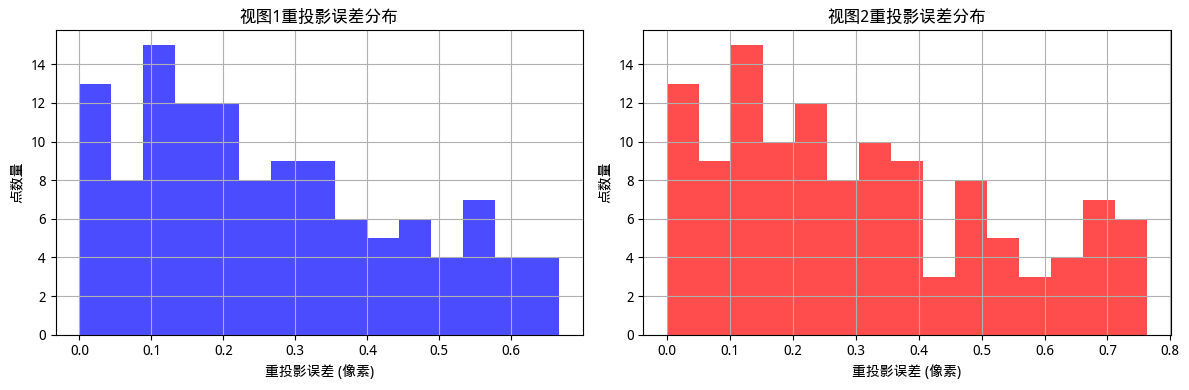

\n=== 3D重建质量评估 ===
  - 原始匹配点：282
  - 高置信度匹配点：282
  - RANSAC内点：122
  - 最终3D点：122
\n✅ 3D重建流程完成！


In [8]:
# 重投影验证和误差分析

if len(points_3d_filtered) > 0 and 'R' in locals() and 't' in locals():
    import matplotlib.pyplot as plt
    
    # 将3D点重投影到两个视图
    points_2d_reproj1, _ = cv2.projectPoints(points_3d_filtered, np.zeros((3, 1)), np.zeros((3, 1)), 
                                            cameraMatrix, distCoeffs)
    points_2d_reproj2, _ = cv2.projectPoints(points_3d_filtered, R, t, cameraMatrix, distCoeffs)
    
    points_2d_reproj1 = points_2d_reproj1.reshape(-1, 2)
    points_2d_reproj2 = points_2d_reproj2.reshape(-1, 2)
    
    # 计算重投影误差
    # 使用对应的原始内点进行误差计算
    num_valid_points = len(points_3d_filtered)
    original_points1 = inlier_points1[:num_valid_points]
    original_points2 = inlier_points2[:num_valid_points]
    
    if len(original_points1) == len(points_2d_reproj1):
        reproj_error1 = np.sqrt(np.sum((original_points1 - points_2d_reproj1)**2, axis=1))
        reproj_error2 = np.sqrt(np.sum((original_points2 - points_2d_reproj2)**2, axis=1))
        
        print(f"\\n=== 重投影误差分析 ===")
        print(f"视图1 - 平均误差: {reproj_error1.mean():.3f} 像素, 最大误差: {reproj_error1.max():.3f} 像素")
        print(f"视图2 - 平均误差: {reproj_error2.mean():.3f} 像素, 最大误差: {reproj_error2.max():.3f} 像素")
        
        # 显示重投影误差分布
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.hist(reproj_error1, bins=15, alpha=0.7, color='blue', label='视图1')
        ax1.set_xlabel('重投影误差 (像素)')
        ax1.set_ylabel('点数量')
        ax1.set_title('视图1重投影误差分布')
        ax1.grid(True)
        
        ax2.hist(reproj_error2, bins=15, alpha=0.7, color='red', label='视图2')
        ax2.set_xlabel('重投影误差 (像素)')
        ax2.set_ylabel('点数量')
        ax2.set_title('视图2重投影误差分布')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    print(f"\\n=== 3D重建质量评估 ===")
    print(f"  - 原始匹配点：{len(mkpts0)}")
    print(f"  - 高置信度匹配点：{len(points1_filtered)}")
    if 'mask' in locals():
        print(f"  - RANSAC内点：{mask.sum()}")
    print(f"  - 最终3D点：{len(points_3d_filtered)}")
    print(f"\\n✅ 3D重建流程完成！")
    
else:
    if len(points_3d_filtered) == 0:
        print("❌ 无法进行重投影验证 - 没有有效的3D点")
    else:
        print("❌ 无法进行重投影验证 - 缺少必要的姿态参数")

In [9]:
# 3D点重建部分 - 相机参数配置

# 设置相机内参（需要根据实际相机标定结果调整）
fx, fy = 1129.779455220537, 1130.37799592189  # 焦距参数
cx, cy = img0_raw.shape[1] / 2, img0_raw.shape[0] / 2  # 主点（图像中心）

# 构建相机内参矩阵
cameraMatrix = np.array([[fx, 0, cx], 
                         [0, fy, cy], 
                         [0, 0, 1]], dtype=np.float32)

# 畸变系数（假设无畸变）
distCoeffs = [0.024457338259660406, -0.19759521637573255, -0.0004954709930047227, 0.008031753518161133, 0.4714296514600179]

print(f"相机内参矩阵：")
print(cameraMatrix)
print(f"匹配点数量：{len(mkpts0)}")
print(f"图像尺寸：{img0_raw.shape}")

相机内参矩阵：
[[1.1297794e+03 0.0000000e+00 3.2000000e+02]
 [0.0000000e+00 1.1303781e+03 2.4000000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
匹配点数量：282
图像尺寸：(480, 640)
